## Step 1: Install & Import Dependencies

In [2]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

## Step 2: Create a 3D MRI Dataset Class

In [3]:

class MRISegmentationDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.root_dir = root_dir
        self._load_dataset()

    def _load_dataset(self):
        subjects = os.listdir(self.root_dir)
        for subject in subjects:
            subject_path = os.path.join(self.root_dir, subject)
            ce_path = os.path.join(subject_path, 'CeT1')
            seg_path = os.path.join(subject_path, 'Segmentation')

            # Skip if folders don't exist
            if not os.path.isdir(ce_path) or not os.path.isdir(seg_path):
                print(f"[WARNING] Missing CeT1 or Segmentation folder for subject: {subject}")
                continue

            ce_files = [f for f in os.listdir(ce_path) if f.endswith('.nii.gz')]
            seg_files = [f for f in os.listdir(seg_path) if f.endswith('.nii.gz')]

            for ce_file, seg_file in zip(sorted(ce_files), sorted(seg_files)):
                ce_full_path = os.path.join(ce_path, ce_file)
                seg_full_path = os.path.join(seg_path, seg_file)

                if os.path.exists(ce_full_path) and os.path.exists(seg_full_path):
                    self.samples.append((ce_full_path, seg_full_path))
                else:
                    print(f"[WARNING] Missing file pair: {ce_full_path}, {seg_full_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ce_path, seg_path = self.samples[idx]
        ce_img = nib.load(ce_path).get_fdata()
        seg_img = nib.load(seg_path).get_fdata()

        ce_tensor = torch.tensor(ce_img, dtype=torch.float32).unsqueeze(0)
        seg_tensor = torch.tensor(seg_img, dtype=torch.float32).unsqueeze(0)

        return ce_tensor, seg_tensor


## Step 3: Simple 3D U-Net Model

In [4]:

# 1st Model
"""class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = nn.Sequential(
            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv3d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv3d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv3d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 16, 3, padding=1),
            nn.ReLU()
        )

        self.out = nn.Conv3d(16, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))"""


'class UNet3D(nn.Module):\n    def __init__(self, in_channels=1, out_channels=1):\n        super(UNet3D, self).__init__()\n        self.enc1 = nn.Sequential(\n            nn.Conv3d(in_channels, 16, 3, padding=1),\n            nn.ReLU(),\n            nn.Conv3d(16, 16, 3, padding=1),\n            nn.ReLU()\n        )\n        self.pool1 = nn.MaxPool3d(2)\n\n        self.enc2 = nn.Sequential(\n            nn.Conv3d(16, 32, 3, padding=1),\n            nn.ReLU(),\n            nn.Conv3d(32, 32, 3, padding=1),\n            nn.ReLU()\n        )\n        self.pool2 = nn.MaxPool3d(2)\n\n        self.bottleneck = nn.Sequential(\n            nn.Conv3d(32, 64, 3, padding=1),\n            nn.ReLU(),\n            nn.Conv3d(64, 64, 3, padding=1),\n            nn.ReLU()\n        )\n\n        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)\n        self.dec2 = nn.Sequential(\n            nn.Conv3d(64, 32, 3, padding=1),\n            nn.ReLU(),\n            nn.Conv3d(32, 32, 3, padding=1),\n          

In [5]:
#Claude code
# 2nd Model
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()  # Simplified super() call
        # Use nn.ModuleList for systematic access to encoder/decoder blocks
        self.encoders = nn.ModuleList([
            self._make_encoder_block(in_channels, 16),
            self._make_encoder_block(16, 32)
        ])
        
        self.pools = nn.ModuleList([nn.MaxPool3d(2) for _ in range(2)])
        
        self.bottleneck = self._make_conv_block(32, 64)
        
        # Store upsampling layers in ModuleList
        self.upsamples = nn.ModuleList([
            nn.ConvTranspose3d(64, 32, 2, stride=2),
            nn.ConvTranspose3d(32, 16, 2, stride=2)
        ])
        
        self.decoders = nn.ModuleList([
            self._make_decoder_block(64, 32),
            self._make_decoder_block(32, 16)
        ])
        
        # Separate output layer with optional normalization
        self.out = nn.Sequential(
            nn.Conv3d(16, out_channels, 1),
            nn.Sigmoid()
        )
    
    def _make_conv_block(self, in_channels, out_channels):
        """Create a convolutional block with inplace ReLU for better memory efficiency"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),  # Remove bias when using BatchNorm
            nn.ReLU(inplace=True),  # Use inplace ReLU to save memory
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
    
    def _make_encoder_block(self, in_channels, out_channels):
        """Create an encoder block"""
        return self._make_conv_block(in_channels, out_channels)
    
    def _make_decoder_block(self, in_channels, out_channels):
        """Create a decoder block"""
        return self._make_conv_block(in_channels, out_channels)
    
    def forward(self, x):
        # Store encoder outputs for skip connections
        encoder_outputs = []
        
        # Encoder path
        for i, (encoder, pool) in enumerate(zip(self.encoders, self.pools)):
            x = encoder(x)
            encoder_outputs.append(x)
            x = pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path with skip connections
        for i, (upsample, decoder) in enumerate(zip(self.upsamples, self.decoders)):
            x = upsample(x)
            # Use encoder outputs in reverse order for skip connections
            skip_connection = encoder_outputs[-(i+1)]
            x = torch.cat([x, skip_connection], dim=1)
            x = decoder(x)
            
        return self.out(x)

## Step 4: Train Loop

In [ ]:
# 1st GPT
"""def dice_loss(pred, target, smooth=5e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = dice_loss

dataset = MRISegmentationDataset(r'C:\Users\OMEN\Desktop\MRI_Synthesis_Project\MRI_SYNTHESIS_PROJECT\data\Resized_dataset\train_resized')
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(1, 20):
    model.train()
    total_loss = 0
    for ce, seg in tqdm(loader):
        ce, seg = ce.to(device), seg.to(device)
        pred = model(ce)
        loss = criterion(pred, seg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Train Dice Loss: {total_loss/len(loader):.4f}")"""


[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1007
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1027
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1028
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1033
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1035
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1040
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1048
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1053
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1054
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1057
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1060
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1065


100%|██████████| 173/173 [01:05<00:00,  2.66it/s]


Epoch 1, Train Dice Loss: -53.9379


100%|██████████| 173/173 [01:07<00:00,  2.55it/s]


Epoch 2, Train Dice Loss: 7.9785


100%|██████████| 173/173 [01:09<00:00,  2.49it/s]


Epoch 3, Train Dice Loss: 10.7131


100%|██████████| 173/173 [01:10<00:00,  2.47it/s]


Epoch 4, Train Dice Loss: 7.6450


100%|██████████| 173/173 [01:10<00:00,  2.46it/s]


Epoch 5, Train Dice Loss: 6.0193


100%|██████████| 173/173 [01:10<00:00,  2.46it/s]


Epoch 6, Train Dice Loss: 5.2531


100%|██████████| 173/173 [01:10<00:00,  2.46it/s]


Epoch 7, Train Dice Loss: 4.7281


100%|██████████| 173/173 [01:10<00:00,  2.46it/s]


Epoch 8, Train Dice Loss: 4.3391


100%|██████████| 173/173 [01:10<00:00,  2.45it/s]


Epoch 9, Train Dice Loss: 4.0294


100%|██████████| 173/173 [01:10<00:00,  2.45it/s]


Epoch 10, Train Dice Loss: 3.7828


100%|██████████| 173/173 [01:10<00:00,  2.45it/s]


Epoch 11, Train Dice Loss: 3.5794


100%|██████████| 173/173 [01:10<00:00,  2.45it/s]


Epoch 12, Train Dice Loss: 3.4111


100%|██████████| 173/173 [01:10<00:00,  2.45it/s]


Epoch 13, Train Dice Loss: 3.2710


100%|██████████| 173/173 [01:10<00:00,  2.44it/s]


Epoch 14, Train Dice Loss: 3.1554


100%|██████████| 173/173 [01:10<00:00,  2.44it/s]


Epoch 15, Train Dice Loss: 3.0605


100%|██████████| 173/173 [01:11<00:00,  2.42it/s]


Epoch 16, Train Dice Loss: 2.9832


100%|██████████| 173/173 [01:14<00:00,  2.33it/s]


Epoch 17, Train Dice Loss: 2.9214


100%|██████████| 173/173 [01:11<00:00,  2.40it/s]


Epoch 18, Train Dice Loss: 2.8722


100%|██████████| 173/173 [01:12<00:00,  2.40it/s]

Epoch 19, Train Dice Loss: 2.8334


C:\Users\OMEN\AppData\Local\Temp\ipykernel_29924\321635104.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None


[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1007
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1027
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1028
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1033
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1035
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1040
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1048
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1053
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1054
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1057
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1060
[WARNING] Missing CeT1 or Segmentation folder for subject: ISPY1_1065


Epoch 1:   0%|          | 0/22 [00:00<?, ?batch/s]

C:\Users\OMEN\AppData\Local\Temp\ipykernel_29924\321635104.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):
Epoch 1: 100%|██████████| 22/22 [17:29<00:00, 47.72s/batch, loss=-33.3241] 


Epoch 1, Train Dice Loss: -33.3241


Epoch 2: 100%|██████████| 22/22 [08:39<00:00, 23.63s/batch, loss=23.9601]


Epoch 2, Train Dice Loss: 23.9601


Epoch 3: 100%|██████████| 22/22 [08:48<00:00, 24.01s/batch, loss=9.6305]  

Epoch 3, Train Dice Loss: 9.6305


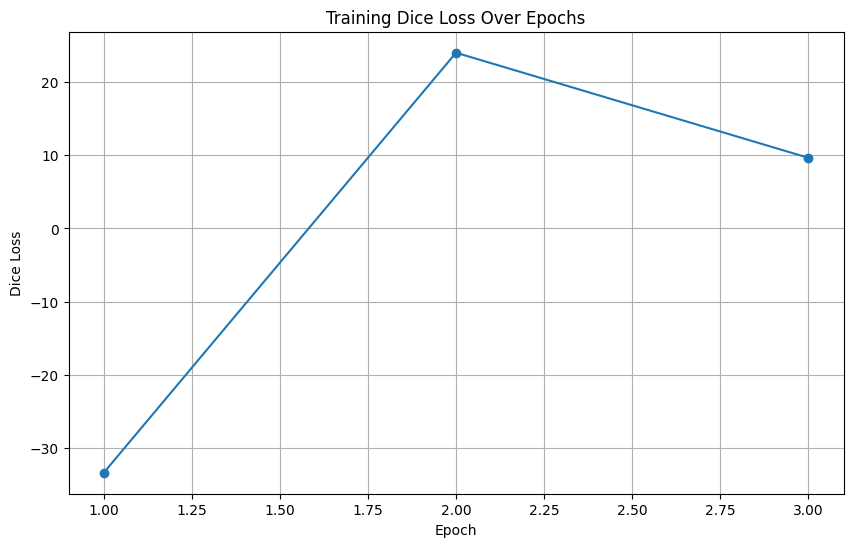

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming UNet3D and MRISegmentationDataset are defined as in your previous context

def dice_loss(pred, target, smooth=0.00001):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet3D().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = dice_loss

dataset = MRISegmentationDataset(r'C:\Users\OMEN\Desktop\MRI_Synthesis_Project\MRI_SYNTHESIS_PROJECT\data\Resized_dataset\train_resized')
loader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0)

scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None

epochs = 3
train_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch}", unit="batch")
    for ce, seg in progress_bar:
        ce, seg = ce.to(device), seg.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            pred = model(ce)
            loss = criterion(pred, seg)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{total_loss/(progress_bar.n + 1):.4f}"})

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}, Train Dice Loss: {avg_loss:.4f}")


# Save the trained model
save_path = "checkpoints/best_unet3d.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Dice Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.grid(True)
plt.savefig('training_loss.png') # Save the plot
plt.show()

In [7]:
""" def dice_loss(pred, target, smooth=1e-5):
    # Ensure we're using float32 for numerical stability
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    # Use more efficient operations
    intersection = torch.sum(pred * target)
    total = torch.sum(pred) + torch.sum(target)
    
    # Return scalar directly
    return 1.0 - (2.0 * intersection + smooth) / (total + smooth)

# Set device with mixed precision support check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
scaler = torch.cuda.amp.GradScaler() if use_amp else None

# Create model with deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
model = UNet3D().to(device)

# Optimize the optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-5,
    eps=1e-8
)

# Create learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2
)

# Use function directly
criterion = dice_loss

# Improved data loading with num_workers and pin_memory
dataset = MRISegmentationDataset(r'C:\Users\OMEN\Desktop\MRI_Synthesis_Project\MRI_SYNTHESIS_PROJECT\data\Resized_dataset\train_resized')
loader = DataLoader(
    dataset, 
    batch_size=1, 
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

# Create output directory for model checkpoints if it doesn't exist
import os
checkpoint_dir = os.path.join('checkpoints', 'unet3d')
os.makedirs(checkpoint_dir, exist_ok=True)

# Define validation function
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    for ce, seg in val_loader:
        ce, seg = ce.to(device, non_blocking=True), seg.to(device, non_blocking=True)
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            pred = model(ce)
            loss = criterion(pred, seg)
        total_loss += loss.item()
    return total_loss / len(val_loader)

# Import necessary packages
from contextlib import nullcontext
import time

# Variables for model saving
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 5

# Training loop with optimizations
for epoch in range(1, 6):
    model.train()
    total_loss = 0
    epoch_start_time = time.time()
    
    with tqdm(loader, desc=f"Epoch {epoch}/5") as pbar:
        for CeT1, Segmentation in pbar:
            # Transfer to device with non-blocking for parallel data transfer
            ce = CeT1.to(device, non_blocking=True)
            seg = Segmentation.to(device, non_blocking=True)
            
            # Zero gradients with better memory efficiency
            optimizer.zero_grad(set_to_none=True)
            
            # Use mixed precision if available
            with torch.cuda.amp.autocast() if use_amp else nullcontext():
                pred = model(ce)
                loss = criterion(pred, seg)
            
            # Backward pass with scale for mixed precision
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
                
            # Update metrics
            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    # Calculate average loss
    avg_loss = total_loss / len(loader)
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch summary
    print(f"Epoch {epoch}, Train Dice Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")
    
    # Save model if it's the best so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        
        # Save model checkpoint with metadata
        checkpoint_path = os.path.join(checkpoint_dir, f'unet3d_best_model_epoch{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'loss': avg_loss,
            'device': device,
            'scaler': scaler.state_dict() if scaler else None,
        }, checkpoint_path)
        
        print(f"✓ Best model saved to {checkpoint_path} (loss: {avg_loss:.4f})")
        
        # Also save a smaller file with just the model weights for inference
        inference_path = os.path.join(checkpoint_dir, 'unet3d_best_model_weights.pt')
        torch.save(model.state_dict(), inference_path)
    else:
        patience_counter += 1
        print(f"! No improvement for {patience_counter} epochs (best: {best_loss:.4f})")
        
        # Save periodic checkpoint regardless of performance
        if epoch % 2 == 0:  # Save every 2 epochs
            checkpoint_path = os.path.join(checkpoint_dir, f'unet3d_checkpoint_epoch{epoch}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"→ Periodic checkpoint saved to {checkpoint_path}")
    
    # Update learning rate based on performance
    scheduler.step(avg_loss)
    
    # Early stopping check
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {patience_counter} epochs without improvement")
        break

# Save final model regardless of performance
final_path = os.path.join(checkpoint_dir, 'unet3d_final_model.pt')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, final_path)
print(f"▶ Training completed. Final model saved to {final_path}")"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 1250-1251: truncated \UXXXXXXXX escape (2597821593.py, line 1)